In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sin, cos, sqrt, atan2,radians
import xgboost

In [2]:
df = pd.read_csv("F:\\python\\newyork\\train.csv",nrows=10000)

In [3]:
test = pd.read_csv("F:\\python\\newyork\\test.csv")

In [4]:
testkey = test.key

In [5]:
df = df.dropna(how = 'any', axis = 'rows')

In [6]:
len(df)

10000

In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
l = df[(df.pickup_latitude > 42.0) | (df.pickup_latitude < 40.0)|(df.dropoff_latitude > 42.0) | (df.dropoff_latitude < 40.0) | (df.pickup_longitude > -73.0) | (df.pickup_longitude < -75.0) | (df.dropoff_longitude > -73.0) | (df.dropoff_longitude < -75.0)].index

In [9]:
df = df.drop(l,axis=0)

In [10]:
z = df[(df.fare_amount > 300.0) | (df.fare_amount < 0.0) |(df.passenger_count > 7.0) | (df.passenger_count < 0.0)].index

In [11]:
df = df.drop(z,axis=0)

In [12]:
len(df)

9788

In [13]:
def distlatlong(lon1,lat1,lon2,lat2):
    lat1=radians(lat1)
    lat2=radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = 6373.0 * c
    return distance


In [14]:
df['dist'] = [distlatlong(df.pickup_longitude[i],df.pickup_latitude[i],df.dropoff_longitude[i],df.dropoff_latitude[i]) for i in df.index]

In [15]:
test['dist'] = [distlatlong(test.pickup_longitude[i],test.pickup_latitude[i],test.dropoff_longitude[i],test.dropoff_latitude[i]) for i in test.index]

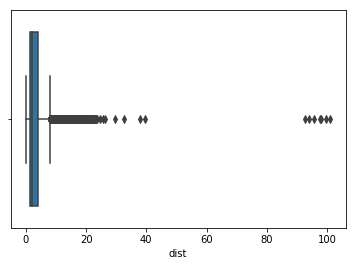

In [16]:
sns.boxplot(df.dist)

In [17]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2.323989
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2.426114
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.618822
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,1.961648
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,5.388992


In [18]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [19]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9788 entries, 0 to 9999
Data columns (total 9 columns):
key                  9788 non-null object
fare_amount          9788 non-null float64
pickup_datetime      9788 non-null datetime64[ns]
pickup_longitude     9788 non-null float64
pickup_latitude      9788 non-null float64
dropoff_longitude    9788 non-null float64
dropoff_latitude     9788 non-null float64
passenger_count      9788 non-null int64
dist                 9788 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.1+ MB


In [21]:
df['latenights'] = [1 if df.pickup_datetime[i].hour < 5 else 0 for i in df.index]
test['latenights'] = [1 if test.pickup_datetime[i].hour < 5 else 0 for i in test.index]

In [22]:
df['year'] = [df.pickup_datetime[i].year for i in df.index]

In [23]:
test['year'] = [test.pickup_datetime[i].year for i in test.index]

In [24]:
df['day'] = [df.pickup_datetime[i].day for i in df.index]

In [25]:
test['day'] = [test.pickup_datetime[i].day for i in test.index]

In [26]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,latenights,year,day
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.031088,0,2009,15
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.452786,0,2010,5
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389961,1,2011,18
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.800149,1,2012,21
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999784,0,2010,9


In [27]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,latenights,year,day
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323989,0,2015,27
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.426114,0,2015,27
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618822,0,2011,8
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961648,0,2012,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.388992,0,2012,1


In [28]:
feat = df.drop(['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)
test = test.drop(['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1)

In [29]:
test.year.unique()

array([2015, 2011, 2012, 2014, 2010, 2013, 2009], dtype=int64)

In [30]:
feat = pd.concat([feat,pd.get_dummies(feat.year)],axis=1)
test = pd.concat([test,pd.get_dummies(test.year)],axis=1)

In [31]:
feat = feat.drop('year',axis=1)

In [32]:
test = test.drop('year',axis=1)

In [33]:
feat.head()

,fare_amount,passenger_count,dist,latenights,day,2009,2010,2011,2012,2013,2014,2015
0,4.5,1,1.031088,0,15,1,0,0,0,0,0,0
1,16.9,1,8.452786,0,5,0,1,0,0,0,0,0
2,5.7,2,1.389961,1,18,0,0,1,0,0,0,0
3,7.7,1,2.800149,1,21,0,0,0,1,0,0,0
4,5.3,1,1.999784,0,9,0,1,0,0,0,0,0


In [34]:
test.head()

,passenger_count,dist,latenights,day,2009,2010,2011,2012,2013,2014,2015
0,1,2.323989,0,27,0,0,0,0,0,0,1
1,1,2.426114,0,27,0,0,0,0,0,0,1
2,1,0.618822,0,8,0,0,1,0,0,0,0
3,1,1.961648,0,1,0,0,0,1,0,0,0
4,1,5.388992,0,1,0,0,0,1,0,0,0


In [35]:
label = feat['fare_amount']

In [36]:
feat = feat.drop('fare_amount',axis=1)

In [37]:
xtr,xts,ytr,yts = train_test_split(feat,label)

In [38]:
xgbtrain = xgboost.DMatrix(xtr,ytr)
xgbtest = xgboost.DMatrix(xts,yts)
xgbfinaltest = xgboost.DMatrix(test)

In [39]:
params={'eval_metric':'rmse','objective':'reg:linear'}

In [40]:
xgbmodel = xgboost.train(params,
                    dtrain=xgbtrain,num_boost_round=150, 
                    early_stopping_rounds=20,evals=[(xgbtest,'test')])

[0]	test-rmse:10.1278
Will train until test-rmse hasn't improved in 20 rounds.
[1]	test-rmse:7.69717
[2]	test-rmse:6.19167
[3]	test-rmse:5.31945
[4]	test-rmse:4.85029
[5]	test-rmse:4.65074
[6]	test-rmse:4.55583
[7]	test-rmse:4.52337
[8]	test-rmse:4.49848
[9]	test-rmse:4.49186
[10]	test-rmse:4.49366
[11]	test-rmse:4.51252
[12]	test-rmse:4.50671
[13]	test-rmse:4.51101
[14]	test-rmse:4.51806
[15]	test-rmse:4.51372
[16]	test-rmse:4.53196
[17]	test-rmse:4.53482
[18]	test-rmse:4.53155
[19]	test-rmse:4.55602
[20]	test-rmse:4.59912
[21]	test-rmse:4.61521
[22]	test-rmse:4.63335
[23]	test-rmse:4.65051
[24]	test-rmse:4.66767
[25]	test-rmse:4.68816
[26]	test-rmse:4.68984
[27]	test-rmse:4.70605
[28]	test-rmse:4.68638
[29]	test-rmse:4.69346
Stopping. Best iteration:
[9]	test-rmse:4.49186



In [41]:
pred = xgbmodel.predict(xgbfinaltest)

In [42]:
pred = pred.round(2)

In [43]:
finalset = pd.DataFrame({'key':testkey,'fare_amount':pred})

In [44]:
finalset = finalset[['key','fare_amount']]

In [45]:
finalset.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.43
1,2015-01-27 13:08:24.0000003,9.69
2,2011-10-08 11:53:44.0000002,4.66
3,2012-12-01 21:12:12.0000002,7.89
4,2012-12-01 21:12:12.0000003,15.13


In [46]:
finalset.to_csv('finaloutput.csv',index=False)